<a href="https://colab.research.google.com/github/Hy-per-ion/ECG-Classification/blob/main/SNN_Spatial_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

class ECGImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {
            'ECG Images of Myocardial Infarction Patients (240x12=2880)': 0,
            'ECG Images of Patient that have History of MI (172x12=2064)': 1,
            'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2,
            'Normal Person ECG Images (284x12=3408)': 3
        }
        self._load_data()

    def _load_data(self):
        for folder in os.listdir(self.root_dir):
            folder_path = os.path.join(self.root_dir, folder)
            label = self.label_map[folder]
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ECGImageDataset('/content/drive/MyDrive/ECG_Data/train', transform=transform)
test_dataset = ECGImageDataset('/content/drive/MyDrive/ECG_Data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply convolution to the feature map to generate an attention map
        attention_map = self.conv1(x)
        attention_map = self.sigmoid(attention_map)
        # Apply the attention map to the input feature map
        return x * attention_map

In [ ]:
class TransformerSNNHybridModelWithAttention(nn.Module):
    def __init__(self, num_classes=4, input_channels=1):
        super(TransformerSNNHybridModelWithAttention, self).__init__()

        # CNN Layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.flatten_size = self.calculate_flatten_size(input_channels, 64)

        # Self-Attention (Encoder)
        self.embedding_dim = 128
        self.self_attention = nn.MultiheadAttention(embed_dim=self.embedding_dim, num_heads=4, batch_first=True)

        # Spatial Attention
        self.spatial_attention = SpatialAttention(in_channels=128)

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def calculate_flatten_size(self, input_channels, input_size):
        dummy_input = torch.zeros(1, input_channels, input_size, input_size)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return int(torch.prod(torch.tensor(x.size())))

    def forward(self, x):
        # CNN Feature Extraction
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Apply Spatial Attention
        x = self.spatial_attention(x)

        # Reshape for Self-Attention
        b, c, h, w = x.size()
        x = x.view(b, c, -1).permute(0, 2, 1)

        # Apply Self-Attention
        x, _ = self.self_attention(x, x, x)

        # Flatten for Fully Connected Layers
        x = x.contiguous().view(b, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.2 MB/s eta 0:00:00


In [ ]:
from brian2 import *

def convert_to_spikes(image, spike_rate=20):
    image = image.numpy()
    image = np.clip(image.flatten(), 0, 1)
    spike_times = []

    # Encoding process
    for i, pixel in enumerate(image):
        spike_lambda = pixel * spike_rate
        if spike_lambda < 0:
            spike_lambda = 0

        # Poisson distribution to generate spikes
        spikes_for_pixel = np.random.poisson(spike_lambda, 1)
        spike_times.extend([i] * spikes_for_pixel)

    return spike_times

# SNN Layer
def snn_layer(input_spikes, num_neurons=100):
    start_scope()
    eqs = '''
    dv/dt = (I - v) / (10*ms) : 1
    I = 0 : 1 (constant)
    '''
    G = NeuronGroup(num_neurons, eqs, threshold='v>1', reset='v=0', method='exact')
    spikes = SpikeMonitor(G)

    for spike in input_spikes:
        G[spike].I = 1

    run(1 * second)
    return spikes.count



In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time / 60)
    seconds = int(elapsed_time % 60)
    return minutes, seconds

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        spike_inputs = [convert_to_spikes(image) for image in inputs]
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            spike_inputs = [convert_to_spikes(image) for image in inputs]
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerSNNHybridModelWithAttention(num_classes=4, input_channels=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

max_epochs = 50
stop_accuracy = 0.99

total_start_time = time.time()

for epoch in range(max_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)
    accuracy = test(model, test_loader, device)
    end_time = time.time()
    epoch_minutes, epoch_seconds = epoch_time(start_time, end_time)
    print(f"Epoch [{epoch + 1}/{max_epochs}], Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_minutes}m {epoch_seconds}s")

    if accuracy >= stop_accuracy:
        print(f"Training stopped as accuracy reached {accuracy * 100:.2f}% at epoch {epoch + 1}.")
        break

total_end_time = time.time()
total_minutes, total_seconds = epoch_time(total_start_time, total_end_time)

print(f"Training completed in {total_minutes}m {total_seconds}s.")

Epoch [1/50], Loss: 1.3841, Accuracy: 0.2500, Time: 5m 1s
Epoch [2/50], Loss: 1.3483, Accuracy: 0.3326, Time: 2m 3s
Epoch [3/50], Loss: 1.2958, Accuracy: 0.3661, Time: 2m 2s
Epoch [4/50], Loss: 1.2571, Accuracy: 0.3616, Time: 2m 4s
Epoch [5/50], Loss: 1.2539, Accuracy: 0.4174, Time: 2m 9s
Epoch [6/50], Loss: 1.2078, Accuracy: 0.3393, Time: 2m 3s
Epoch [7/50], Loss: 1.2345, Accuracy: 0.4129, Time: 2m 3s
Epoch [8/50], Loss: 1.1856, Accuracy: 0.4576, Time: 1m 59s
Epoch [9/50], Loss: 1.2097, Accuracy: 0.4420, Time: 2m 6s
Epoch [10/50], Loss: 1.1797, Accuracy: 0.4308, Time: 2m 1s
Epoch [11/50], Loss: 1.1642, Accuracy: 0.5402, Time: 2m 1s
Epoch [12/50], Loss: 1.0838, Accuracy: 0.5290, Time: 2m 2s
Epoch [13/50], Loss: 1.0095, Accuracy: 0.5558, Time: 1m 58s
Epoch [14/50], Loss: 0.9651, Accuracy: 0.6049, Time: 1m 59s
Epoch [15/50], Loss: 0.8790, Accuracy: 0.6094, Time: 2m 0s
Epoch [16/50], Loss: 0.8558, Accuracy: 0.5871, Time: 2m 2s
Epoch [17/50], Loss: 0.8516, Accuracy: 0.5982, Time: 1m 59s
Ep

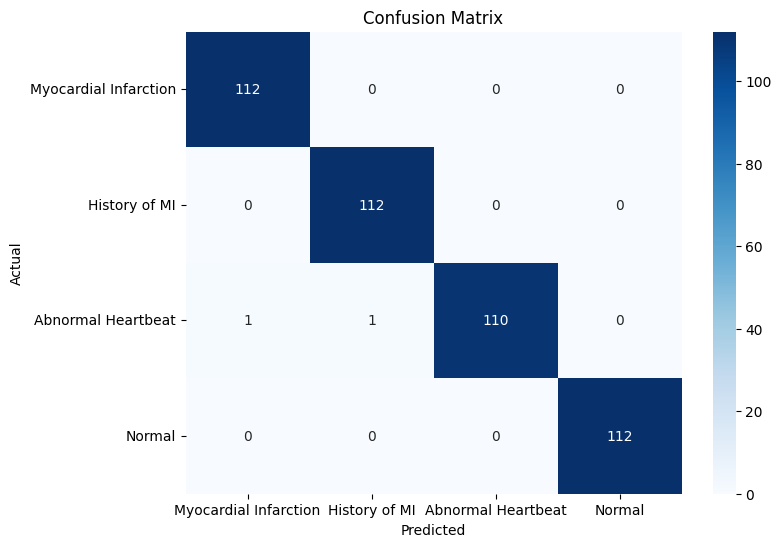

Classification Report:
                        precision    recall  f1-score   support

Myocardial Infarction       0.99      1.00      1.00       112
        History of MI       0.99      1.00      1.00       112
   Abnormal Heartbeat       1.00      0.98      0.99       112
               Normal       1.00      1.00      1.00       112

             accuracy                           1.00       448
            macro avg       1.00      1.00      1.00       448
         weighted avg       1.00      1.00      1.00       448

Accuracy: 0.9955
Precision: 0.9956
Recall: 0.9955
F1 Score: 0.9955


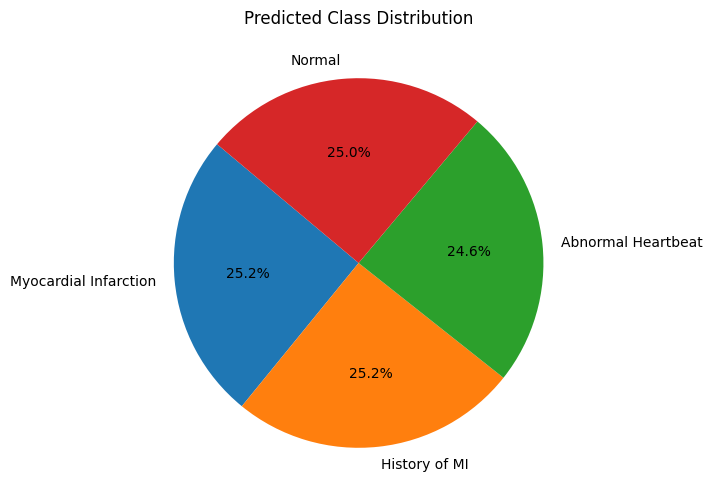

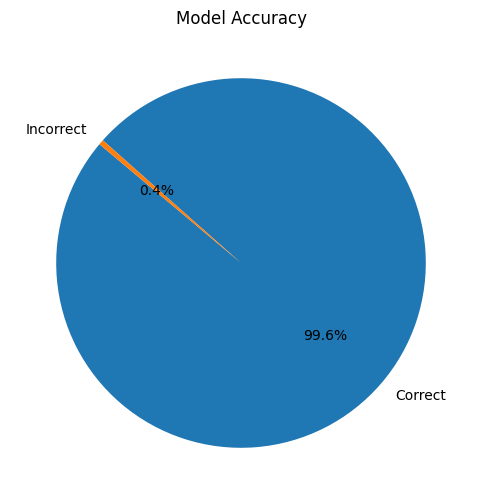

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(all_labels, all_preds):
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Myocardial Infarction', 'History of MI', 'Abnormal Heartbeat', 'Normal'],
                yticklabels=['Myocardial Infarction', 'History of MI', 'Abnormal Heartbeat', 'Normal'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    class_report = classification_report(all_labels, all_preds, target_names=['Myocardial Infarction', 'History of MI', 'Abnormal Heartbeat', 'Normal'])
    print("Classification Report:\n", class_report)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Pie chart (predicted class distribution)
    class_counts = np.bincount(all_preds)
    labels = ['Myocardial Infarction', 'History of MI', 'Abnormal Heartbeat', 'Normal']
    plt.figure(figsize=(6, 6))
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Predicted Class Distribution')
    plt.show()

    # Pie chart (accuracy)
    correct = int(accuracy * len(all_labels))
    incorrect = len(all_labels) - correct
    plt.figure(figsize=(6, 6))
    plt.pie([correct, incorrect], labels=['Correct', 'Incorrect'], autopct='%1.1f%%', startangle=140)
    plt.title('Model Accuracy')
    plt.show()

def test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

all_preds, all_labels = test(model, test_loader, device)
evaluate_model(all_labels, all_preds)
